# Classificación: Classificador Bayesiano

Vamos a leer inicialmente los datos:

In [25]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
random.seed(42) # definir la semilla (importante para reproducir los resultados)

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/BreastCancer.csv', header=(0))
data = pd.read_csv('data/Iris.csv', header=(0))
#data = pd.read_csv('data/Vehicle.csv', header=(0))

data = data.dropna(axis='rows') #Remueve los NaN, recuerde que puede realizar mejores cosas aqui, puede decir imputar

# Almacenar los nombres de las clases
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

nrow, ncol = data.shape
print("Matriz de atributos: Número de filas:", nrow, " columnas: ", ncol)
attributes = list(data.columns)
data.head(10)

Matriz de atributos: Número de filas: 150  columnas:  5


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


Vamos a construir las variables $X$ y $y$, dado que el proceso de estimacionón se resume en estimar la función $f$ en la relación $y = f(X) + \epsilon$, en donde $\epsilon$ es el error, que tiene distribución normal con media igual a cero e variância $\sigma^2$.

Convertimos los datos al formato Numpy para facilitar su manipulación. 

In [26]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Vamos estandarizar los datos, parae evitar el efecto de la escala de los atributos.

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [28]:
print('Datos transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desviación estandar:', np.std(X, axis = 0))

Datos transformados:
Media:  [-4.73695157e-16 -6.63173220e-16  3.31586610e-16 -2.84217094e-16]
Desviación estandar: [1. 1. 1. 1.]


Para entrenar el clasificador, necesitamos definfir un conjunto de prueba y otro de entrenamiento.

In [29]:
from sklearn.model_selection import train_test_split
p = 0.8 # fraccion de elementos en el conjunto de entreinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

A partir de este conjunto de datos, podemos realizar una clasificación.

## Clasificador Bayesiano

Consideraremos el caso paramétrico, suponiendo que cada variable se distribuye según una distribución Normal. También se pueden utilizar otras distribuciones.

Ya hemos seleccionado previamente los conjuntos de entrenamiento y de prueba. En el conjunto de entrenamiento, calcularemos la media y la desviación estándar de cada atributo para cada clase. A continuación, volvemos a clasificar los datos utilizando la teoría de la decisión bayesiana, es decir: $X \in C_i$ si y sólo si, $P(C_i|X) = \max P(C_j|X)$ para todo $j$.

In [65]:
from scipy.stats import multivariate_normal

# matrix to store the probabilities
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

Pc = np.zeros(len(classes)) #fracción de elementos en cada clase
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i])) # los indices de los datos de prueba que son de la clase i
    Pc[i] = len(elements)/len(y_train) # Probabilidad de la clase
    Z = x_train[elements,:][0] # Los Xs que forman parte de la clase i
    m = np.mean(Z, axis = 0)  # media para cada atributo de la clase i
    cv = np.cov(np.transpose(Z))# matriz de covarianzas para cada atributo de la clase i
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)  # cálculo de la verosimilitud para cada X en el conjunto de entrenamiento con relación a la clase i
        P[classes[i]][j] = pj*Pc[i] # aproximación de la probabilidad (recuerde que estamos obviando el calculo de la probabilidad de x)

In [66]:
print(P)
P.shape


           setosa    versicolor     virginica
0    5.222359e-81  2.945646e-04  9.166228e-06
1    3.993102e-03  7.431078e-31  8.110944e-69
2   1.067023e-248  8.603394e-17  1.815611e-07
3    2.820299e-80  1.521963e-02  3.042943e-05
4    4.932364e-95  3.479563e-03  1.695083e-06
5    3.420186e-03  5.383535e-24  1.726400e-59
6    2.005769e-46  1.157144e-03  6.897817e-11
7   1.744342e-143  1.474870e-14  5.570747e-05
8    3.431034e-90  1.163796e-05  1.720325e-05
9    1.142509e-53  1.670497e-02  9.673918e-09
10  1.386013e-122  8.856863e-06  1.066864e-03
11   1.592254e-02  1.929137e-22  1.502870e-51
12   2.777886e-03  2.481343e-30  3.349138e-71
13   1.422831e-02  1.696864e-23  2.274204e-52
14   3.199454e-02  2.993137e-31  8.647473e-66
15   1.976666e-88  5.565696e-03  1.203536e-06
16  5.659689e-166  8.718523e-09  3.794368e-03
17   2.776260e-52  1.255261e-02  1.071293e-07
18   2.394801e-74  3.686118e-03  2.675612e-05
19  1.299825e-158  2.161779e-10  2.685433e-03
20   2.196493e-02  2.157852e-22  1

(30, 3)

Calculamos los valores de clasificación usando la regla de decisión Bayesiana, es decir realizamos nuestra predicción de la clase Y, posteriormente la comparamos con el valor de y observado en la base de datos de prueba y medimos la precisión. 

In [32]:
y_pred = []
#np.array(test_x.shape[0], dtype=str)
for i in np.arange(0, x_test.shape[0]): 
    c = np.argmax(np.array(P.iloc[[i]])) # identificamos el indicador de la columna con mayor probabilidad en la matriz P
    y_pred.append(classes[c]) # asignamos la clase asociada al indicador c a la predicción de y
y_pred = np.array(y_pred, dtype=str) # convertimos en matriz de tipo string
print(y_pred)

['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'virginica' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa']


In [33]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.9666666666666667


Código completo.

In [34]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

random.seed(42) 

data = pd.read_csv('data/Iris.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Convertir a matriz y vector numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma los datos para que tengan media igual a cero y varianza igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Selecciona los conjuntos de entrenamiento y prueba
p = 0.8 #Fracción de elementos en el conjunto de pruebas
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

####  Realiza la clasificación ####
# Matriz que almancena las probabilidades para cada clase
P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 

Pc = np.zeros(len(classes)) # Almacena la fracción de elementos de cada clase
for i in np.arange(0, len(classes)): # Para cada clase
    elements = tuple(np.where(y_train == classes[i])) #elementos de la clase i
    Pc[i] = len(elements)/len(y_train) # Probabilidad de pertenecer a la clase i
    Z = x_train[elements,:][0] # Elementos del conjunto de entrenamiento
    m = np.mean(Z, axis = 0) # Vetor de medias
    cv = np.cov(np.transpose(Z)) # Matriz de covarinza
    for j in np.arange(0,x_test.shape[0]): # para cada observación en el conjunto de prueba
        x = x_test[j,:]
        # calcula la probabilidad de pertencer a cada clase
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com las classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calculo de la precisión
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.9666666666666667


## Caso no paramétrico

Para el caso unidimensional, sea $(X_1,X_2, \ldots, X_n)$ una muestra aleatoria unidimensional idénticamente distribuida según alguna función de distribución desconocida $f$. Para estimar la forma de $f$, utilizamos un estimador de densidad de núcleo:
\begin{equation}
\widehat{f}_{h}(x)={\frac {1}{n}}\sum _{i=1}^{n}K_{h}(x-x_{i})={\frac {1}{nh}}\sum _{i=1}^{n}K{\Big (}{\frac {x-x_{i}}{h}}{\Big )},
\end{equation}
onde $K$ es una función Kernel. 
La estimación depende del parámetro $h$, que es un parámetro libre y controla la apertura de la función.

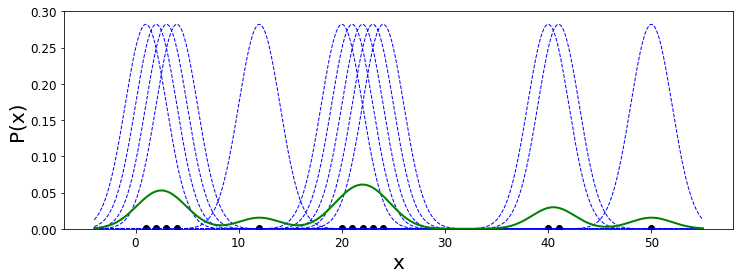

In [35]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
# genera los datos
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))
# muestra los datos
plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

# valores x que se utilizarán en las densidades
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2 
fhat = 0 # estimación obtenida
for x in X:
    # distribución normal centrada en x
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f # acumula las distribuciones
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

# muestra la distribución estimada
plt.plot(X_plot,fhat/(len(X)*np.sqrt(h)), color = 'green', linewidth=2)
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))
plt.savefig('kernel-ex.eps')
plt.show(True)

Esse resultado pode ser obtido usando-se a função KernelDensity scikit-learn.

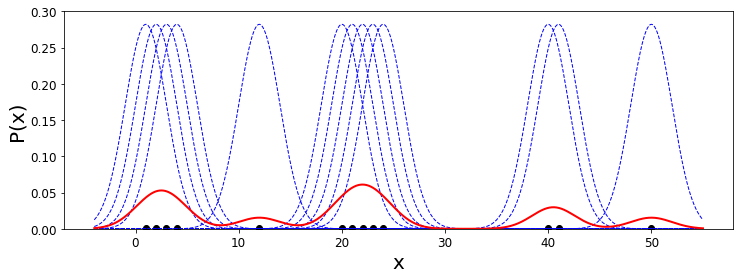

In [36]:
import numpy as np
from matplotlib.pyplot import cm
from sklearn.neighbors import KernelDensity

color=['red', 'blue', 'magenta', 'gray', 'green']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2
fhat = 0
for x in X:
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'red', linewidth=2, label = 'h='+str(h))    
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))

plt.show(True)

Nótese que la forma de la estimación depende del parámetro libre $h$.

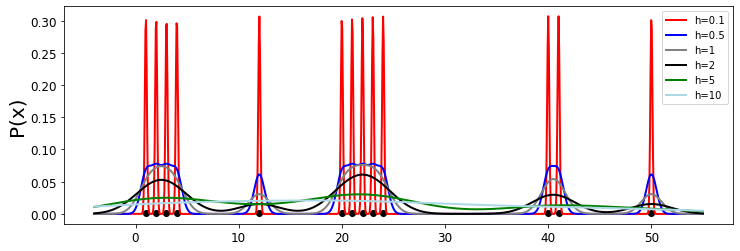

In [37]:
import numpy as np
from matplotlib.pyplot import cm

color=['red', 'blue', 'gray', 'black', 'green', 'lightblue']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
c = 0
vh = [0.1, 0.5, 1, 2, 5, 10]
for h in vh:
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
    log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
    plt.plot(X_plot,log_dens, color = color[c], linewidth=2, label = 'h='+str(h))
    c = c + 1
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim((0, 0.2))
plt.legend(fontsize = 10)
#plt.savefig('kernel.eps')
plt.show(True)

Tenga en cuenta que la estimación está relacionada con la estimación mediante histogramas.

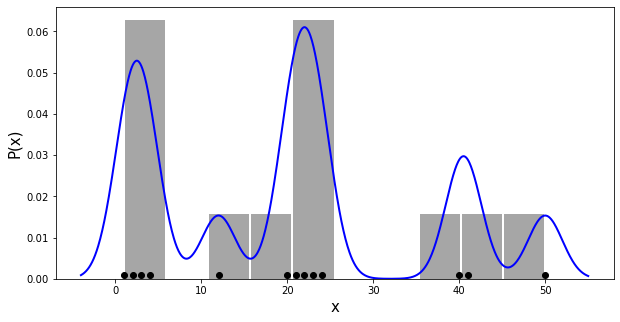

In [38]:
import numpy as np

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(10,5))
# Histogram
nbins = 10
plt.hist(X,bins = nbins, density = True, color='gray',alpha=0.7, rwidth=0.95)

#Kernel density estimation
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'blue', linewidth=2)
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
plt.xlabel('x', fontsize = 15)
plt.ylabel('P(x)', fontsize = 15)

plt.show(True)

Utilizando el método de *kernel density estimation*, podemos realizar la clasificación.

In [39]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score

random.seed(42)
data = pd.read_csv('data/Iris.csv', header=(0))
# data = pd.read_csv('data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 2
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.9666666666666667


### Ejercicios

1 - Considerar otras distribuciones al clasificar los datos, además de la Normal.<br>
2 - Comprobar cómo influye el parámetro $h$ en la clasificación.

